In [2]:
import numpy as np
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
from numba import jit
import time
from torch.utils.data import Dataset, DataLoader
from scipy.sparse.csgraph import dijkstra
import torch.optim as optim
from torch.optim import lr_scheduler
from scipy.linalg import eigh
import networkx as nx

In [3]:
num_gpus = torch.cuda.device_count()
print(num_gpus)

1


In [2]:
## renvoie une partition de l'ensemble set_ sous la forme d'une liste contenant toutes les partitions

def partition(set_):
    if not set_:
        return [[]]
    else:
        a = set_.pop()
        rec_sets = partition(set_)
        output = []
        for rec_set in rec_sets:
            rec_set_copy = rec_set.copy()
            rec_set_copy.append([a])
            output.append(rec_set_copy)
            for set in rec_set:
                rec_set_copy = rec_set.copy()
                set_copy = set.copy()
                rec_set_copy.remove(set)
                set_copy.append(a)
                rec_set_copy.append(set_copy)
                output.append(rec_set_copy)
    return output

print(partition({1,2,3}))

[[[3], [2], [1]], [[2], [3, 1]], [[3], [2, 1]], [[3, 2], [1]], [[3, 2, 1]]]


In [3]:
import time
def generate_pattern(k):
    """
    Input:
        k : int
    Output:
        patterns (b(k) * k) : all equality patterns. b(k) is the kth Bell number.
                A row [i_1, ..., i_k] contains integers where equality between p and q is denoted by i_p == i_q
    """
    t=time.time()
    sets = partition(list(range(k)))
    patterns = np.zeros((len(sets), k), dtype=int)
    for (p_ind,pattern) in enumerate(sets):
        for (i_ind,ind_set) in enumerate(pattern):
            for i in ind_set:
                patterns[p_ind, i] = i_ind
    return patterns

print(generate_pattern(10).shape)

(115975, 10)


In [4]:


def generate_bias(n, k):
    """
    the biases are generated according to Marcon article (see p6)
    Generate the 2 different order-k bias
    Input:
        n : int
        k : 2 or 3
    Output:
        output: n^k * b(k) Tensor
    """
    if k == 1:
        pattern = [0]
        output = torch.ones(n)
    if k == 2:
        pattern = generate_pattern(2)
        output = torch.zeros(n,n,len(pattern))
        for p_ind in range(len(pattern)):
            ind = np.zeros(2, dtype=int)
            for i1 in range(n): # not efficient rn !! to jitify
                for i2 in range(n):
                    add_one = True
                    ind = [i1, i2]
                    # test if every equality pattern is respected
                    for j in range(2):
                        for l in range(j):
                            add_one = add_one and \
                                ((ind[j] == ind[l]) == (pattern[p_ind,j] == pattern[p_ind,l]))
                    if add_one:
                        output[i1,i2,p_ind] = 1
    elif k == 3:
        pattern = generate_pattern(3)
        output = torch.zeros(n,n,n,len(pattern))
        for p_ind in range(len(pattern)):
            #ind = np.zeros(3, dtype=int)
            for i1 in range(n):
                for i2 in range(n):
                    for i3 in range(n):
                        add_one = True
                        ind = [i1, i2, i3]
                        # test if every equality pattern is respected
                        for j in range(3):
                            for l in range(j):
                                add_one = add_one and \
                                    ((ind[j] == ind[l]) == (pattern[p_ind,j] == pattern[p_ind,l]))
                        if add_one:
                            output[i1,i2,i3,p_ind] = 1
    elif k == 4:
        pattern = generate_pattern(4)
        output = torch.zeros(n,n,n,n,len(pattern))
        for p_ind in range(len(pattern)):
            #ind = np.zeros(3, dtype=int)
            for i1 in range(n):
                for i2 in range(n):
                    for i3 in range(n):
                        for i4 in range(n):
                            add_one = True
                            ind = [i1, i2, i3, i4]
                            # test if every equality pattern is respected
                            for j in range(4):
                                for l in range(j):
                                    add_one = add_one and \
                                        ((ind[j] == ind[l]) == (pattern[p_ind,j] == pattern[p_ind,l]))
                            if add_one:
                                output[i1,i2,i3,i4,p_ind] = 1
    elif k==5:
        pattern= generate_pattern(5)
        output=torch.zeros(n,n,n,n,n,len(pattern))
        for p_ind in range(len(pattern)):
            for i1 in range(n):
                for i2 in range(n):
                    for i3 in range(n):
                        for i4 in range(n):
                            for i5 in range(n):
                                add_one=True
                                ind=[i1, i2, i3, i4, i5]
                                for j in range(5):
                                    for l in range(j):
                                        add_one = add_one and \
                                           ((ind[j] == ind[l]) == (pattern[p_ind,j] == pattern[p_ind,l]))
                                if add_one:
                                    output[i1,i2,i3,i4,i5,p_ind] = 1
    elif k==6:
        pattern= generate_pattern(6)
        output=torch.zeros(n,n,n,n,n,n,len(pattern))
        for p_ind in range(len(pattern)):
            for i1 in range(n):
                for i2 in range(n):
                    for i3 in range(n):
                        for i4 in range(n):
                            for i5 in range(n):
                                for i6 in range(n):
                                    add_one=True
                                    ind=[i1, i2, i3, i4, i5, i6]
                                    for j in range(6):
                                        for l in range(j):
                                            add_one = add_one and \
                                               ((ind[j] == ind[l]) == (pattern[p_ind,j] == pattern[p_ind,l]))
                                    if add_one:
                                        output[i1,i2,i3,i4,i5,i6,p_ind] = 1
    return torch.reshape(output, (n**k, len(pattern)))

#print(generate_bias(4,5))

@jit(nopython=True)
def transforminput1(Ws, pattern, bk):
    n_sample, n = Ws.shape[0], Ws.shape[1]
    output = np.zeros((n_sample, n, bk), dtype=np.float32)
    
    for p_ind in range(bk):
        for i1 in range(n):
            for i2 in range(n):
                for i3 in range(n):
                        ind = [i1, i2, i3]
                        add_one = True
                        for j in range(3):
                            for k in range(j):
                                add_one = add_one and \
                                    ((ind[j] == ind[k]) == (pattern[p_ind,j] == pattern[p_ind,k]))
                        if add_one:
                            output[:,i1,p_ind] += Ws[:,i2, i3]

    return output

@jit(nopython=True)
def transforminput2(Ws, pattern, bk):
    n_sample, n = Ws.shape[0], Ws.shape[1]
    output = np.zeros((n_sample, n, n, bk), dtype=np.float32)
    
    for p_ind in range(bk):
        for i1 in range(n):
            for i2 in range(n):
                for i3 in range(n):
                    for i4 in range(n):
                        ind = [i1, i2, i3, i4]
                        add_one = True
                        for j in range(4):
                            for k in range(j):
                                add_one = add_one and \
                                    ((ind[j] == ind[k]) == (pattern[p_ind,j] == pattern[p_ind,k]))
                        if add_one:
                            output[:,i1,i2,p_ind] += Ws[:,i3, i4]

    return output

@jit(nopython=True)
def transforminput3(Ws, pattern, bk):
    n_sample, n = Ws.shape[0], Ws.shape[1]
    output = np.zeros((n_sample, n, n, n, bk), dtype=np.float32)
    
    for p_ind in range(bk):
        for i1 in range(n):
            for i2 in range(n):
                for i3 in range(n):
                    for i4 in range(n):
                        for i5 in range(n):
                            ind = [i1, i2, i3, i4, i5]
                            add_one = True
                            for j in range(5):
                                for k in range(j):
                                    add_one = add_one and \
                                        ((ind[j] == ind[k]) == (pattern[p_ind,j] == pattern[p_ind,k]))
                            if add_one:
                                output[:,i1,i2,i3,p_ind] += Ws[:,i4,i5]
    return output

def transforminput(Ws,k):
    """ 
    Transform a collection of graphs into equivariant basis of order-k
    Input:
        Ws (n_sample * n * n Tensor): graphs
        k : 2 or 3
    Output:
        output (n_sample * n^k * b(k+2)): equivariant basis
    """
    n_sample, n = Ws.shape[0], Ws.shape[1]
    pattern = generate_pattern(k+2)
    if k==1:
        output = transforminput1(Ws.numpy(), pattern, len(pattern)) # jitified function, used without torch
    elif k==2:
        output = transforminput2(Ws.numpy(), pattern, len(pattern)) # jitified function, used without torch
    elif k==3:
        output = transforminput3(Ws.numpy(), pattern, len(pattern))
    return torch.reshape(torch.Tensor(output), (n_sample, n**k, len(pattern)))

#%% data
    
def SBM(n_sample, n, K = 10, connectivity=(0.85, 0.05)):
    
    def _symmetric_matrix_from_vector(vec, n):
        """Construct a symmetrized matrix from a vector X of size n*(n+1)/2
        """
        tind = np.triu_indices(n)
        tempX = np.zeros((n, n))
        tempX[tind] = vec
        np.fill_diagonal(tempX, 0)
        tempX = tempX + tempX.T
        return tempX
    
    l = int(n*(n+1)/2)
    A = np.zeros((n_sample, n, n))
    P = np.zeros((n_sample, n, n))
    
    (lam, alpha) = connectivity
    connectivity_mat = alpha*(lam*np.eye(K) + (1-lam)*(np.ones((K, K))))
    
    tind = np.triu_indices(n)
    for i in range(n_sample):
        communities = np.floor(np.random.rand(n)*K).astype(int)
        commx, commy = np.meshgrid(communities, communities)
        connec = (connectivity_mat[commx, commy])[tind]
        # P and A are (lenff, n(n+1)/2)
        P[i,:,:] = _symmetric_matrix_from_vector(connec, n)
        A[i,:,:] = _symmetric_matrix_from_vector(np.random.rand(l) < connec, n)
        
    return A, P

tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])


In [5]:
class ToyGraphs(Dataset):
    def __init__(self, n_sample, n, k, mode = 'invariant',
                 type_graph = 'normal', type_label = 'shortest_path', transform_data = True):
        """
        Input:
          n_sample : number of samples
          n : number of nodes
          k : tensorization inside networks, 2 or 3
          mode : 'invariant' or 'equivariant'
          type_graphs:
            'normal': normal edge weights (symmetrized, with absolute value)
            'SBM': stochastic block model with K=sqrt(log(n))+1 communities
          type_label:
            'shortest_path': diameter (longest shortest path) if invariant, longest shortest path from each node if equivariant
            'eigen': second largest eigenvalue is invariant, second eigenvector if equivariant
        Data:
          self.equi (n_sample * n^k * b(k+2)): data, equivariant basis form
          self.label (n_sample if invariant, n_sample * n if equivariant)
        """
        self.n = n
        self.n_sample = n_sample
        self.mode = mode
        self.k = k
        
        if type_graph == 'normal':
            self.Ws = torch.randn(n_sample,n,n)
            for i in range(n_sample):
                self.Ws[i,:,:] = torch.abs(self.Ws[i,:,:] + self.Ws[i,:,:].t())
        elif type_graph == 'SBM':
            self.Ws, _ = torch.tensor(SBM(n_sample, n, K = int(np.sqrt(np.log(n)))+1, connectivity = (0.85, 4*np.log(n)/n)))
        elif type_graph == 'special':
            choice = np.random.randint(5, size=n_sample)
            weights = torch.abs(torch.randn(n_sample,n,n)) + 0.01#*(torch.randn(n_sample))[:,None,None])
            self.Ws = torch.zeros(n_sample, n, n)
            for i in range(n_sample):
                weight = weights[i,:,:] + weights[i,:,:].t()
                if choice[i] == 0:
                    A = nx.complete_graph(n)
                elif choice[i] == 1:
                    A = nx.cycle_graph(n)
                elif choice[i] == 2:
                    A = nx.path_graph(n)
                elif choice[i] == 3:
                    A = nx.star_graph(n-1)
                elif choice[i] == 4:
                    A = nx.wheel_graph(n)
                self.Ws[i,:,:] = torch.tensor(nx.to_numpy_array(A)).float() * weight
        
        if mode == 'equivariant':
            self.label = torch.zeros(n_sample,n)
        else:
            self.label = torch.zeros(n_sample)
        for i in range(n_sample):
            if type_label == 'shortest_path':
                if mode == 'equivariant':
                    self.label[i,:] = torch.tensor(np.max(dijkstra(self.Ws[i,:,:], directed=False), axis=0))
                else:
                    self.label[i] = np.max(dijkstra(self.Ws[i,:,:], directed=False))
            elif type_label == 'eigen':
                A = self.Ws[i,:,:].numpy()
                eig_values, eig_vec = eigh(A.dot(A), eigvals=[n-1,n-1])
                if mode == 'equivariant':
                    self.label[i,:] = torch.tensor(eig_vec).t()
                else:
                    self.label[i] = torch.tensor(eig_values)
        
        print('Create equivariant basis...')
        self.equi = transforminput(self.Ws, k)
        print('Done.')
        
    def __len__(self):
        return self.n_sample
    
    def __getitem__(self, idx):
        if self.mode == 'equivariant':
            #return self.Ws[idx,:,:],self.equi[idx,:,:], self.label[idx,:]
            return self.equi[idx,:,:], self.label[idx,:]
        else:
            #return self.Ws[idx,:,:],self.equi[idx,:,:], self.label[idx]
            return self.equi[idx,:,:], self.label[idx]

In [6]:
mode = 'invariant' # invariant or equivariant
type_label = 'shortest_path'
type_graph = 'special'
n_sample = 1000 # -- 7000 in the paper
ns = [5, 10] # database contain graphs of both number of nodes (half / half) -- [5, 10] in the paper
k = 2 # tensor order to test, 1 or 2 or 3
modes=['invariant','equivariant']
toygraph=ToyGraphsBiSize(n_sample, ns, k = k, mode = mode, type_graph = type_graph, type_label = type_label)

print(toygraph[10][0].shape)
print(toygraph[10][3].shape)
print(toygraph[10][0])

NameError: name 'ToyGraphsBiSize' is not defined

In [7]:
class ToyGraphsBiSize(Dataset):
    def __init__(self, n_sample, ns, k = 2, mode = 'invariant',
                 type_graph = 'normal', type_label = 'shortest_path', transform_data = True):
        self.data1 = ToyGraphs(n_sample, ns[0], k = k, mode = mode, type_graph = type_graph, type_label = type_label, transform_data = transform_data)
        self.data2 = ToyGraphs(n_sample, ns[1], k = k, mode = mode, type_graph = type_graph, type_label = type_label, transform_data = transform_data)
      
    def __len__(self):
        return self.data1.n_sample
    
    def __getitem__(self, idx):
        return (self.data1.__getitem__(idx)[0], self.data1.__getitem__(idx)[1],#,self.data1.__getitem__(idx)[2],
                self.data2.__getitem__(idx)[0], self.data2.__getitem__(idx)[1])#, self.data1.__getitem__(idx)[2],)

#%% main class
class GNN(nn.Module):
    def __init__(self, k, s, mode = 'invariant', nonlin = 'sigmoid', init_n = 10):
        
        """
            k: 2 or 3. Order of tensor inside network.
            s: int. number of channels.
            mode: invariant or equivariant
        """
        
        super(GNN, self).__init__()
        self.s = s
        self.k = k
        self.mode = mode
        
        self.length_equiweight = len(generate_pattern(2+k)) # 15 or 52
        if self.mode == 'equivariant':
            self.length_outputweight = len(generate_pattern(k+1)) # 5 or 15
        else: 
            self.length_outputweight = len(generate_pattern(k)) # 2 or 5
        
        if nonlin == 'sigmoid':
            self.nonlin = torch.sigmoid
        
        self.equiweight = nn.Parameter(torch.Tensor(self.length_equiweight, s))
        self.equibias = nn.Parameter(torch.Tensor(len(generate_pattern(k)), s))
        self.outputweight = nn.Parameter(torch.Tensor(self.length_outputweight, s))
        self.bias = nn.Parameter(torch.Tensor(1)) # scalar ?

        # initialize weights
        torch.nn.init.normal_(self.equiweight, std=np.sqrt(1/(s*init_n**k*self.length_equiweight)))
        torch.nn.init.constant_(self.equibias, val=0)
        torch.nn.init.normal_(self.outputweight, std=np.sqrt(1/(s*init_n**k*self.length_outputweight))) # n=10
        torch.nn.init.constant_(self.bias, val = 0)

    def forward(self, input, equi_bias = None, equi_output = None,unique=False):
        """
        Input:
            input (n_sample * n^k * b(2+k)): mini batch of graphs in their equivariant basis
            equi_bias (n^k * b(k)) : bias inside non-linearity
                    equal to generate_bias(n,k) in practice, however it is better not to regenerate it each time.
                    (since n can vary)
                    Therefore we pass it as a parameter.
            equi_output (n * n^k * b(k+1)) : equivariant basis for final output.
                    equal to torch.reshape(generate_bias(n,k+1), (n, n**k, -1)) in practice
        Output:
            output (n_sample)
        """
        
        if equi_bias is None:
            n = int(input.shape[0]**(1/self.k))
            equi_bias = generate_bias(n, self.k)
        if equi_output is None and self.mode == 'equivariant':
            n = int(input.shape[0]**(1/self.k))
            equi_output = torch.reshape(generate_bias(n, self.k+1), (n, n**self.k, -1))
        
        if unique:
            print(self.equiweight.shape)
            print(input[:,:,None].shape)
            temp = self.nonlin(
                    (input[:,:,None] * self.equiweight[None, None, :,:]).sum(2) + \
                    ((equi_bias[:,:,None] * self.equibias[None, :, :]).sum(1))[None, : :])
        else:
            temp = self.nonlin(
                    (input[:,:,:,None] * self.equiweight[None, None, :,:]).sum(2) + \
                    ((equi_bias[:,:,None] * self.equibias[None, :, :]).sum(1))[None, : :]
                    ) # n_sample * n^k * s
        if self.mode == 'equivariant':
            output = (self.outputweight[None,None,None,:,:] *\
                      (equi_output[None,:,:,:,None] *temp[:,None,:,None,:])).sum((2,3,4)) + self.bias # n_sample * n
        else:
            output = (self.outputweight[None,None, :,:] *\
                      (equi_bias[None,:,:,None] *temp[:,:,None,:])).sum((1,2,3)) + self.bias # n_sample
            
        return output


In [64]:
print(toygraph[500][4].shape)

torch.Size([100, 15])


nb expe: 0
Create equivariant basis...
Done.
Create equivariant basis...
Done.
Create equivariant basis...
Done.
Create equivariant basis...
Done.
nb expe: 1
Create equivariant basis...
Done.
Create equivariant basis...
Done.
Create equivariant basis...
Done.
Create equivariant basis...
Done.
nb expe: 2
Create equivariant basis...
Done.
Create equivariant basis...
Done.
Create equivariant basis...
Done.
Create equivariant basis...
Done.
nb expe: 0
Create equivariant basis...
Done.
Create equivariant basis...
Done.
Create equivariant basis...
Done.
Create equivariant basis...
Done.
nb expe: 1
Create equivariant basis...
Done.
Create equivariant basis...
Done.
Create equivariant basis...
Done.
Create equivariant basis...
Done.
nb expe: 2
Create equivariant basis...
Done.
Create equivariant basis...
Done.
Create equivariant basis...
Done.
Create equivariant basis...
Done.
nb expe: 0
Create equivariant basis...
Done.
Create equivariant basis...
Done.
Create equivariant basis...
Done.
Creat

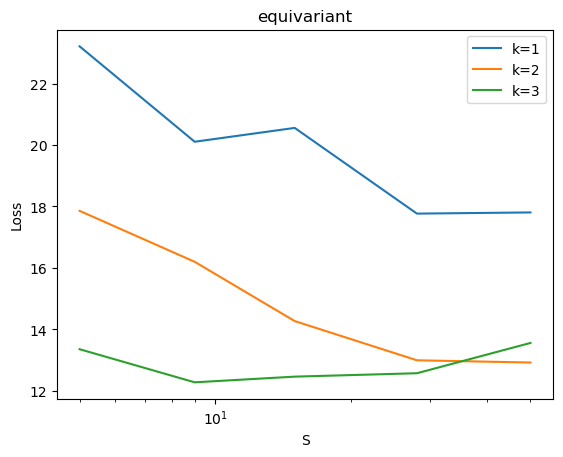

In [7]:
#%% expe

np.random.seed(0)
mode = 'equivariant' # invariant or equivariant
type_label = 'shortest_path'
type_graph = 'special'
n_sample = 1000 # -- 7000 in the paper
ns = [5, 10] # database contain graphs of both number of nodes (half / half) -- [5, 10] in the paper
k = 3 # tensor order to test, 1 or 2 or 3
ss = np.exp(np.linspace(np.log(5.1), np.log(50.1), 5)).astype(int) # widths to test -- from 5 to 100 with 5 points in the paper
nb_expe = 3 # number of experiments to average -- 5 in the paper
modes=['invariant','equivariant']

ks=[1,2,3]

displayloss = torch.zeros(len(ss),3)
for k_index, k in enumerate(ks):
    for i in range(nb_expe):
        print('nb expe:', i)
        np.random.seed(i)

        datatrain = ToyGraphsBiSize(n_sample, ns, k = k, mode = mode, type_graph = type_graph, type_label = type_label)
        datatest = ToyGraphsBiSize(int(n_sample/2), ns, k = k, mode = mode, type_graph = type_graph, type_label = type_label)

        bsize = 14
        dataloader = DataLoader(datatrain, batch_size=bsize, shuffle=True)
        datatestloader = DataLoader(datatest, batch_size=bsize*3, shuffle=True)

        for (ind_s,s) in enumerate(ss):
            num_epochs = 50 # -- 50*k in the paper
            model = GNN(k,s, mode = mode)
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            if torch.cuda.device_count() > 1:
                model = nn.DataParallel(model)
            model.to(device)

            criterion = nn.MSELoss(reduction='sum')
            optimizer = optim.Adam(model.parameters(), lr=0.001)
            # we use two schedulers: a constant but slow decrease, and a plateau one
            scheduler = lr_scheduler.StepLR(optimizer, step_size=24, gamma=0.1*k)
            scheduler2 = lr_scheduler.ReduceLROnPlateau(optimizer, patience = 2*k, verbose = True)
            # auxiliary quantities
            bias = [generate_bias(ns[0],k).to(device), generate_bias(ns[1],k).to(device)]
            output_op = [torch.reshape(generate_bias(ns[0], k+1), (ns[0], ns[0]**k, -1)).to(device),
                         torch.reshape(generate_bias(ns[1], k+1), (ns[1], ns[1]**k, -1)).to(device)]
            for epoch in range(num_epochs):

                t=time.time()
                for inputs0, labels0, inputs1, labels1 in dataloader:
                    inputs = [inputs0.to(device), inputs1.to(device)]
                    labels = [labels0.to(device), labels1.to(device)]
                    for j in [0,1]:
                        optimizer.zero_grad()
                        outputs = model(inputs[j], bias[j], output_op[j])
                        loss = criterion(outputs, labels[j])
                        loss.backward()
                        optimizer.step()
                with torch.no_grad():
                    train_loss = 0.0
                    for inputs0, labels0, inputs1, labels1 in dataloader:
                        inputs = [inputs0.to(device), inputs1.to(device)]
                        labels = [labels0.to(device), labels1.to(device)]
                        for j in [0,1]:
                            outputs = model(inputs[j], bias[j], output_op[j])

                            loss = criterion(outputs, labels[j])
                            train_loss += loss.item()/(2*n_sample)
                    test_loss = 0.0
                    for inputs0, labels0, inputs1, labels1 in datatestloader:
                        inputs = [inputs0.to(device), inputs1.to(device)]
                        labels = [labels0.to(device), labels1.to(device)]
                        for j in [0,1]:
                            #if j==1:
                                #print('input',inputs[j].shape,inputs[j])
                            outputs = model(inputs[j], bias[j], output_op[j])
                            outputs_print=outputs.cpu()
                            labels_print=labels[j].cpu()
                            #print('labels',labels_print.numpy())
                            #print('--------------')
                            #print('outputs',outputs_print.numpy())
                            loss = criterion(outputs, labels[j])
                            test_loss += loss.item()/(n_sample)
                    #print('Epoch {}/{} '.format(epoch, num_epochs - 1) +\
                     #   'Loss: {:.4f}, {:.4f}, time: {:.4f}'.format(train_loss, test_loss, time.time()-t))

                scheduler.step()
            displayloss[ind_s,k_index] += test_loss
        displayloss[:, k_index] /= nb_expe

        
for k_index, k in enumerate(ks):
    plt.semilogx(ss, displayloss[:, k_index], label='k={}'.format(k))

plt.xlabel('S')
plt.ylabel('Loss')
plt.title(mode)
plt.legend()
plt.show()

In [105]:
model_saved=model

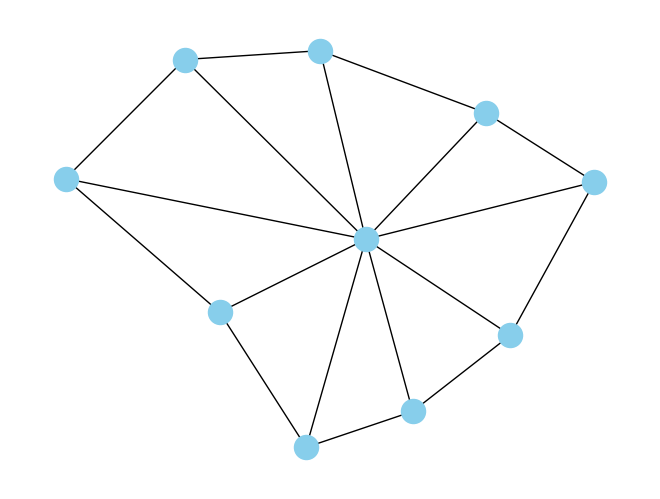

In [86]:
def plot_graph(adjacency_matrix_tensor):
    adjacency_matrix=adjacency_matrix_tensor.numpy()
    G=nx.Graph(adjacency_matrix)
    pos = nx.spring_layout(G)

    nx.draw(G, pos, node_size=300, node_color='skyblue', font_size=10)

    # Affichez le graphe
    plt.show()
plot_graph(toygraph[700][3])

In [95]:
device= torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
k=2
ns=[5,10]

bias = [generate_bias(ns[0],k).to(device), generate_bias(ns[1],k).to(device)]
inputs=toygraph[900][4].to(device)
output_op = [torch.reshape(generate_bias(ns[0], k+1), (ns[0], ns[0]**k, -1)).to(device),
             torch.reshape(generate_bias(ns[1], k+1), (ns[1], ns[1]**k, -1)).to(device)]
output=model_saved.forward(inputs,bias[1], output_op[1],unique=True)
output_print=output.cpu()
print(output_print.detach().numpy()[0])
print(toygraph[900][5].numpy())

torch.Size([15, 50])
torch.Size([100, 15, 1])
3.96802
5.8873367


In [28]:
"""
from sklearn.metrics import mean_squared_error

mode = 'invariant' # invariant or equivariant
type_label = 'shortest_path'
type_graph = 'special'
n_sample = 50 # -- 7000 in the paper
ns = [5, 10] # database contain graphs of both number of nodes (half / half) -- [5, 10] in the paper
k = 3 # tensor order to test, 1 or 2 or 3
modes=['invariant','equivariant']

def compute_predictions(model, mode, type_label, type_graph, n_sample, ns=[5,10], k=3):
    device= torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    toygraph=ToyGraphsBiSize(n_sample, ns, k = k, mode = mode, type_graph = type_graph, type_label = type_label)
    predictions_5=np.zeros((n_sample))
    predictions_10=np.zeros((n_sample))
    
    labels_5=toygraph[:][1]
    labels_10=toygraph[:][3]
    
    bias = [generate_bias(ns[0],k).to(device), generate_bias(ns[1],k).to(device)]
    output_op = [torch.reshape(generate_bias(ns[0], k+1), (ns[0], ns[0]**k, -1)).to(device),
                 torch.reshape(generate_bias(ns[1], k+1), (ns[1], ns[1]**k, -1)).to(device)]
    for i in range(n_sample):
        inputs_5=toygraph[i][0].to(device)
        inputs_10=toygraph[i][2].to(device)
        
        output_5=model.forward(inputs_5,bias[0], output_op[0],unique=True)
        output_5=output_5.cpu()
        predictions_5[i]=output_5.detach().numpy()
        
        output_10=model.forward(inputs_10,bias[1], output_op[1],unique=True)
        output_10=output_10.cpu()
        predictions_10[i]=output_10.detach().numpy()
        
    return (labels_5, predictions_5), (labels_10, predictions_10)

def plot_predictions_vs_labels(labels, predictions):
    plt.plot(labels, label='Labels')
    plt.plot(predictions, label='Predictions')
    plt.xlabel('Index of the graph')
    plt.legend()
    plt.show()
    
labels, predictions=compute_predictions(model_saved, mode, type_label, type_graph, n_sample, ns=[5,10], k=3)[0][0],\
compute_predictions(model_saved, mode, type_label, type_graph, n_sample, ns=[5,10], k=3)[0][1]
correlation_matrix=np.corrcoef(labels, predictions)
mean_sq_error=mean_squared_error(labels, predictions)
print('MSE=',mean_sq_error)
corr_coeff=correlation_matrix[0,1]
print('Correlation coefficient', corr_coeff)
plot_predictions_vs_labels(labels, predictions)
"""

'\nfrom sklearn.metrics import mean_squared_error\n\nmode = \'invariant\' # invariant or equivariant\ntype_label = \'shortest_path\'\ntype_graph = \'special\'\nn_sample = 50 # -- 7000 in the paper\nns = [5, 10] # database contain graphs of both number of nodes (half / half) -- [5, 10] in the paper\nk = 3 # tensor order to test, 1 or 2 or 3\nmodes=[\'invariant\',\'equivariant\']\n\ndef compute_predictions(model, mode, type_label, type_graph, n_sample, ns=[5,10], k=3):\n    device= torch.device("cuda:0" if torch.cuda.is_available() else "cpu")\n\n    toygraph=ToyGraphsBiSize(n_sample, ns, k = k, mode = mode, type_graph = type_graph, type_label = type_label)\n    predictions_5=np.zeros((n_sample))\n    predictions_10=np.zeros((n_sample))\n    \n    labels_5=toygraph[:][1]\n    labels_10=toygraph[:][3]\n    \n    bias = [generate_bias(ns[0],k).to(device), generate_bias(ns[1],k).to(device)]\n    output_op = [torch.reshape(generate_bias(ns[0], k+1), (ns[0], ns[0]**k, -1)).to(device),\n      

# Tentative d'ajout d'une 2e layer

In [8]:
class ToyGraphsBiSize(Dataset):
    def __init__(self, n_sample, ns, k1, mode = 'invariant',
                 type_graph = 'normal', type_label = 'shortest_path', transform_data = True):
        self.data1 = ToyGraphs(n_sample, ns[0], k = k1, mode = mode, type_graph = type_graph, type_label = type_label, transform_data = transform_data)
        self.data2 = ToyGraphs(n_sample, ns[1], k = k1, mode = mode, type_graph = type_graph, type_label = type_label, transform_data = transform_data)
      
    def __len__(self):
        return self.data1.n_sample
    
    def __getitem__(self, idx):
        return (self.data1.__getitem__(idx)[0], self.data1.__getitem__(idx)[1],#,self.data1.__getitem__(idx)[2],
                self.data2.__getitem__(idx)[0], self.data2.__getitem__(idx)[1])#, self.data1.__getitem__(idx)[2],)

#%% main class
class GNN_2layers(nn.Module):
    def __init__(self, k1, k2,s, mode = 'invariant', nonlin = 'sigmoid', init_n = 10):
        
        """
            k1: 2 or 3. Order of tensor inside first layer.
            k2: 2 or 3. Order of tensor inside second layer
            s: int. number of channels. for simplicity and as s does not seem to have a huge impact on output, we take the same
            s for both channels
            mode: invariant or equivariant
            nonlin: we keep the same non-linearity for both layers
        """
        
        super(GNN_2layers, self).__init__()
        self.s = s
        self.k1 = k1
        self.k2=k2
        self.mode = mode
        
        self.length_equiweight_1 = len(generate_pattern(2+k1)) # 15 or 52
        self.length_equiweight_2=len(generate_pattern(k1+k2))
        if self.mode == 'equivariant':
            self.length_outputweight_1 = len(generate_pattern(k1+1)) # 5 or 15
            self.length_outputweight_2=len(generate_pattern(k2+k1))
        else: 
            self.length_outputweight_1 = len(generate_pattern(k1)) # 2 or 5
            self.length_outputweight_2=len(generate_pattern(k2+k1))
        
        if nonlin == 'sigmoid':
            self.nonlin = torch.sigmoid
        
        self.equiweight = nn.Parameter(torch.Tensor(self.length_equiweight_1, s))
        self.equibias = nn.Parameter(torch.Tensor(len(generate_pattern(k1)), s))
        self.outputweight = nn.Parameter(torch.Tensor(self.length_outputweight_1, s))
        self.bias = nn.Parameter(torch.Tensor(1)) # scalar ?
        
        self.hidden_equiweight=nn.Parameter(torch.Tensor(self.length_equiweight_2,s,s)) #F_ij
        self.hidden_equibias=nn.Parameter(torch.Tensor(len(generate_pattern(k2)),s,s))#B_ij
        self.hidden_weight=nn.Parameter(torch.Tensor(self.length_outputweight_2,s,s))#H_ij

        # initialize weights
        torch.nn.init.normal_(self.equiweight, std=np.sqrt(1/(s*init_n**k1*self.length_equiweight_1)))
        torch.nn.init.constant_(self.equibias, val=0)
        torch.nn.init.normal_(self.outputweight, std=np.sqrt(1/(s*init_n**k1*self.length_outputweight_1))) # n=10
        torch.nn.init.constant_(self.bias, val = 0)
                                                       
        torch.nn.init.normal(self.hidden_equiweight,std=np.sqrt(1/(s*init_n**k2*self.length_equiweight_2)))
        torch.nn.init.constant_(self.hidden_equibias, val=0)
        torch.nn.init.normal(self.hidden_weight, std=np.sqrt(1/(s*init_n**k1*self.length_outputweight_2)))

    def forward(self, input, equi_bias = None, equi_output = None, hidden_equiweight= None, 
                hidden_equibias= None, hidden_equioutput= None, unique=False):
        """
        Input:
            input (n_sample * n^k * b(2+k)): mini batch of graphs in their equivariant basis
            equi_bias (n^k1 * b(k1)) : bias inside non-linearity
                    equal to generate_bias(n,k) in practice, however it is better not to regenerate it each time.
                    (since n can vary)
                    Therefore we pass it as a parameter.
            equi_output (n * n^k1 * b(k2+1)) : equivariant basis for final output.
                    equal to torch.reshape(generate_bias(n,k+1), (n, n**k, -1)) in practice
            hidden_equibias (n^k2*b(k2)): bias inside non-linearity for hidden layer
            
            hidden_equioutput (n* n^k2 * b(k2+k1)): equivariant basis for hidden output (from R**n^k2 to R**n^k1)
        Output:
            output (n_sample)
        """
        
        if equi_bias is None:
            n = int(input.shape[0]**(1/self.k1))
            equi_bias = generate_bias(n, self.k1)
                                                       
        if hidden_equibias is None:
            n=int(input.shape[0]**(1/self.k1)) #the order tensorization is the second dimension 
            hidden_equibias=generate_bias(n,self.k2)
        
        if hidden_equiweight is None:
            n=int(input.shape[0]**(1/self.k1))
            hidden_equiweight=torch.reshape(generate_bias(n,self.k1 + self.k2), (n**self.k2, n**self.k1, -1))
            #basis of the equivariant operators between R**k2 and R**k1                                           
                       
        if equi_output is None and self.mode == 'equivariant':
            n = int(input.shape[0]**(1/self.k1))
            equi_output = torch.reshape(generate_bias(n, self.k1+1), (n, n**self.k1, -1)) # basis of the equivariant operators 
                                                       #between R**k1 and R*n
                                                       
        if hidden_equioutput is None: #the H_ij must be equivariant
            n = int(input.shape[0]**(1/self.k2))
            hidden_equioutput = torch.reshape(generate_bias(n, self.k2+self.k1), (n**self.k1, n**self.k2, -1))
        
                                                       
        temp1 = self.nonlin( #no changes here
                (input[:,:,:,None] * self.equiweight[None, None, :,:]).sum(2) + \
                ((equi_bias[:,:,None] * self.equibias[None, :, :]).sum(1))[None, : :]
                ) # n_sample * n^k1 * s

        hidden=self.nonlin(
            ((self.hidden_equiweight[None, None, None, :, :, :]* hidden_equiweight[None, :, :, :, None, None])\
             *temp1[:, None, :, None, :, None]).sum((2,3)) +  
            ((self.hidden_equibias[None, :, :, :] * hidden_equibias[:, :, None, None]).sum(1))[None, :, :, :] #[n_sample, n*k2, s, s]
        )
            
        temp2=((self.hidden_weight[None, None, None, :, :, :] * hidden_equioutput[None, :, :, :, None, None])*\
               hidden[:, None, :, None, :, :]).sum((2,3,5)) # n_sample * n^k1 * s
        
        if self.mode == 'equivariant':
            output = (self.outputweight[None,None,None,:,:] *\
                      (equi_output[None,:,:,:,None] *temp2[:,None,:,None,:])).sum((2,3,4)) + self.bias # n_sample * n
        else:
            output = (self.outputweight[None,None, :,:] *\
                      (equi_bias[None,:,:,None] *temp2[:,:,None,:])).sum((1,2,3)) + self.bias # n_sample
            
        return output


In [33]:
#%% expe

np.random.seed(0)
mode = 'invariant' # invariant or equivariant
type_label = 'shortest_path'
type_graph = 'special'
n_sample = 1000 # -- 7000 in the paper
ns = [5, 10] # database contain graphs of both number of nodes (half / half) -- [5, 10] in the paper
k1 = 3 # tensor order to test, 1 or 2 or 3
k2=2 # tensor order for hidden layer to test, 1 or 2 or 3
#ss = np.exp(np.linspace(np.log(5.1), np.log(50.1), 3)).astype(int) # widths to test -- from 5 to 100 with 5 points in the paper
ss=np.exp(np.linspace(np.log(5.1), np.log(15.1), 3)).astype(int)
nb_expe = 3 # number of experiments to average -- 5 in the paper
modes=['invariant','equivariant']

ks=[(3,2)]
accumulation_steps=4

displayloss = torch.zeros(len(ss),len(ks))
for k_index, k_tuple in enumerate(ks):
    for i in range(nb_expe):
        print('nb expe:', i)
        np.random.seed(i)

        datatrain = ToyGraphsBiSize(n_sample, ns, k_tuple[0], mode = mode, type_graph = type_graph, type_label = type_label)
        datatest = ToyGraphsBiSize(int(n_sample/2), ns, k_tuple[0], mode = mode, type_graph = type_graph, type_label = type_label)

        bsize = 7
        dataloader = DataLoader(datatrain, batch_size=bsize, shuffle=True)
        datatestloader = DataLoader(datatest, batch_size=bsize*3, shuffle=True)

        for (ind_s,s) in enumerate(ss):
            num_epochs = 50 # -- 50*k in the paper
            model = GNN_2layers(k_tuple[0], k_tuple[1], s, mode = mode)
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            if torch.cuda.device_count() > 1:
                model = nn.DataParallel(model)
            model.to(device)

            criterion = nn.MSELoss(reduction='sum')
            optimizer = optim.Adam(model.parameters(), lr=0.001)
            # we use two schedulers: a constant but slow decrease, and a plateau one
            scheduler = lr_scheduler.StepLR(optimizer, step_size=24, gamma=0.1*k_tuple[0])
            scheduler2 = lr_scheduler.ReduceLROnPlateau(optimizer, patience = 2*k_tuple[0], verbose = True)
            # auxiliary quantities
            bias = [generate_bias(ns[0],k_tuple[0]).to(device), generate_bias(ns[1],k_tuple[0]).to(device)]
            hidden_bias=[generate_bias(ns[0],k_tuple[1]).to(device), generate_bias(ns[1],k_tuple[1]).to(device)]
            output_op = [torch.reshape(generate_bias(ns[0], k_tuple[0]+1), (ns[0], ns[0]**k_tuple[0], -1)).to(device),
                         torch.reshape(generate_bias(ns[1], k_tuple[0]+1), (ns[1], ns[1]**k_tuple[0], -1)).to(device)]
            print('s=',s,'nb exp=', i, 'output_op generated')
            hidden_op=[torch.reshape(generate_bias(ns[0], k_tuple[1]+k_tuple[0]), 
                                     (ns[0]**k_tuple[1], ns[0]**k_tuple[0], -1)).to(device),
                         torch.reshape(generate_bias(ns[1], k_tuple[0]+k_tuple[1]), 
                                       (ns[1]**k_tuple[1], ns[1]**k_tuple[0], -1)).to(device)]
            print('s=',s,'nb exp=', i, 'hidden_op generated')

            hidden_output_op=[torch.reshape(generate_bias(ns[0], k_tuple[1]+k_tuple[0]), 
                                     (ns[0]**k_tuple[0], ns[0]**k_tuple[1], -1)).to(device),
                         torch.reshape(generate_bias(ns[1], k_tuple[0]+k_tuple[1]), 
                                       (ns[1]**k_tuple[0], ns[1]**k_tuple[1], -1)).to(device)]
            print('s=',s,'nb exp=', i, 'hidden_output_op generated')

            for epoch in range(num_epochs):

                t=time.time()
                for inputs0, labels0, inputs1, labels1 in dataloader:
                    inputs = [inputs0.to(device), inputs1.to(device)]
                    labels = [labels0.to(device), labels1.to(device)]
                    for j in [0,1]:
                        optimizer.zero_grad()
                        outputs = model(inputs[j], bias[j], output_op[j],
                                           hidden_op[j], hidden_bias[j],
                                           hidden_output_op[j])

                        loss = criterion(outputs, labels[j])
                        loss.backward()
                        
                    #if (batch_counter % accumulation_steps) == 0:
                     #   optimizer.step()
                      #  optimizer.zero_grad()

                   # batch_counter += 1
                        optimizer.step()
                with torch.no_grad():
                    train_loss = 0.0
                    for inputs0, labels0, inputs1, labels1 in dataloader:
                        inputs = [inputs0.to(device), inputs1.to(device)]
                        labels = [labels0.to(device), labels1.to(device)]
                        for j in [0,1]:
                            outputs = model(inputs[j], bias[j], output_op[j],
                                           hidden_op[j], hidden_bias[j],
                                           hidden_output_op[j])

                            loss = criterion(outputs, labels[j])
                            train_loss += loss.item()/(2*n_sample)
                    test_loss = 0.0
                    for inputs0, labels0, inputs1, labels1 in datatestloader:
                        inputs = [inputs0.to(device), inputs1.to(device)]
                        labels = [labels0.to(device), labels1.to(device)]
                        for j in [0,1]:
                            #if j==1:
                                #print('input',inputs[j].shape,inputs[j])
                            outputs = model(inputs[j], bias[j], output_op[j],
                                           hidden_op[j], hidden_bias[j],
                                           hidden_output_op[j])

                            outputs_print=outputs.cpu()
                            labels_print=labels[j].cpu()
                            #print('labels',labels_print.numpy())
                            #print('--------------')
                            #print('outputs',outputs_print.numpy())
                            loss = criterion(outputs, labels[j])
                            test_loss += loss.item()/(n_sample)
                    print('Epoch {}/{} '.format(epoch, num_epochs - 1) +\
                        'Loss: {:.4f}, {:.4f}, time: {:.4f}'.format(train_loss, test_loss, time.time()-t))

                scheduler.step()
            displayloss[ind_s,k_index] += test_loss
        displayloss[:, k_index] /= nb_expe

        
for k_index, k_tuple in enumerate(ks):
    plt.semilogx(ss, displayloss[:, k_index], label='(k1, k2)={}'.format(k_tuple))

plt.xlabel('S')
plt.ylabel('Loss')
plt.title(mode)
plt.legend()
plt.show()

nb expe: 0
Create equivariant basis...
Done.
Create equivariant basis...
Done.
Create equivariant basis...
Done.
Create equivariant basis...
Done.


/tmp/ipykernel_2710/2934773929.py:60: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  torch.nn.init.normal(self.hidden_equiweight,std=np.sqrt(1/(s*init_n**k2*self.length_equiweight_2)))
/tmp/ipykernel_2710/2934773929.py:62: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  torch.nn.init.normal(self.hidden_weight, std=np.sqrt(1/(s*init_n**k1*self.length_outputweight_2)))


s= 5 nb exp= 0 output_op generated
s= 5 nb exp= 0 hidden_op generated
s= 5 nb exp= 0 hidden_output_op generated


OutOfMemoryError: CUDA out of memory. Tried to allocate 10.17 GiB (GPU 0; 14.76 GiB total capacity; 1.06 GiB already allocated; 10.12 GiB free; 4.13 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [29]:
displayloss_k1_k2[0,0,:,:]=displayloss

#print(displayloss_k1_k2)
print(displayloss)
print(displayloss_k1_k2)

tensor([[2.9929],
        [2.9155],
        [2.9651]])
tensor([[[[2.9929],
          [2.9155],
          [2.9651]],

         [[2.8321],
          [2.7998],
          [3.1510]],

         [[3.1638],
          [3.8373],
          [3.5574]]],


        [[[2.4701],
          [2.6792],
          [2.3569]],

         [[3.0048],
          [2.1960],
          [3.4417]],

         [[0.0000],
          [0.0000],
          [0.0000]]],


        [[[2.0744],
          [1.8394],
          [1.9830]],

         [[0.0000],
          [0.0000],
          [0.0000]],

         [[0.0000],
          [0.0000],
          [0.0000]]]])


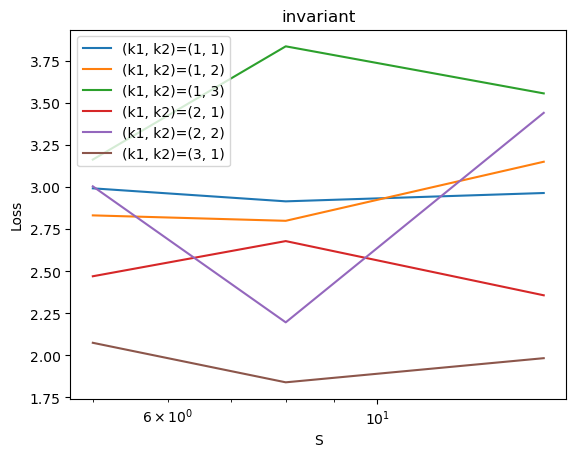

In [31]:
ss=np.exp(np.linspace(np.log(5.1), np.log(15.1), 3)).astype(int)
ks=[(1,1),(1,2),(1,3),(2,1),(2,2),(3,1)]

for k_index, k_tuple in enumerate(ks):
    plt.semilogx(ss, displayloss_k1_k2[k_tuple[0]-1, k_tuple[1]-1, :, :], label='(k1, k2)={}'.format(k_tuple))

plt.xlabel('S')
plt.ylabel('Loss')
plt.title(mode)
plt.legend()
plt.show()

In [ ]:
#%% expe

np.random.seed(0)
mode = 'equivariant' # invariant or equivariant
type_label = 'shortest_path'
type_graph = 'special'
n_sample = 1000 # -- 7000 in the paper
ns = [5, 10] # database contain graphs of both number of nodes (half / half) -- [5, 10] in the paper
k1 = 3 # tensor order to test, 1 or 2 or 3
k2=2 # tensor order for hidden layer to test, 1 or 2 or 3
ss = np.exp(np.linspace(np.log(5.1), np.log(50.1), 5)).astype(int) # widths to test -- from 5 to 100 with 5 points in the paper
nb_expe = 3 # number of experiments to average -- 5 in the paper
modes=['invariant','equivariant']

ks=[(1,1),(1,2),(1,3),(2,1),(2,2),(2,3),(3,1),(3,2),(3,3)]

displayloss = torch.zeros(len(ss),len(ks))
for k_index, k_tuple in enumerate(ks):
    for i in range(nb_expe):
        print('nb expe:', i)
        np.random.seed(i)

        datatrain = ToyGraphsBiSize(n_sample, ns, k = k_tuple[0], mode = mode, type_graph = type_graph, type_label = type_label)
        datatest = ToyGraphsBiSize(int(n_sample/2), ns, k = k_tuple[0], mode = mode, type_graph = type_graph, type_label = type_label)

        bsize = 14
        dataloader = DataLoader(datatrain, batch_size=bsize, shuffle=True)
        datatestloader = DataLoader(datatest, batch_size=bsize*3, shuffle=True)

        for (ind_s,s) in enumerate(ss):
            num_epochs = 50 # -- 50*k in the paper
            model = GNN(k_tuple[0], k_tuple[1], s, mode = mode)
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            if torch.cuda.device_count() > 1:
                model = nn.DataParallel(model)
            model.to(device)

            criterion = nn.MSELoss(reduction='sum')
            optimizer = optim.Adam(model.parameters(), lr=0.001)
            # we use two schedulers: a constant but slow decrease, and a plateau one
            scheduler = lr_scheduler.StepLR(optimizer, step_size=24, gamma=0.1*k_tuple[0])
            scheduler2 = lr_scheduler.ReduceLROnPlateau(optimizer, patience = 2*k_tuple[0], verbose = True)
            # auxiliary quantities
            bias = [generate_bias(ns[0],k_tuple[0]).to(device), generate_bias(ns[1],k_tuple[0]).to(device)]
            hidden_bias=[generate_bias(ns[0],k_tuple[1]).to(device), generate_bias(ns[1],k_tuple[1]).to(device)]
            output_op = [torch.reshape(generate_bias(ns[0], k_tuple[0]+1), (ns[0], ns[0]**k_tuple[0], -1)).to(device),
                         torch.reshape(generate_bias(ns[1], k_tuple[0]+1), (ns[1], ns[1]**k_tuple[0], -1)).to(device)]
            hidden_op=[torch.reshape(generate_bias(ns[0], k_tuple[1]+k_tuple[0]), 
                                     (ns[0]**k_tuple[1], ns[0]**k_tuple[0], -1)).to(device),
                         torch.reshape(generate_bias(ns[1], k_tuple[0]+k_tuple[1]), 
                                       (ns[1]**k_tuple[1], ns[1]**k_tuple[0], -1)).to(device)]
            hidden_output_op=[torch.reshape(generate_bias(ns[0], k_tuple[1]+k_tuple[0]), 
                                     (ns[0]**k_tuple[0], ns[0]**k_tuple[1], -1)).to(device),
                         torch.reshape(generate_bias(ns[1], k_tuple[0]+k_tuple[1]), 
                                       (ns[1]**k_tuple[0], ns[1]**k_tuple[1], -1)).to(device)]
            for epoch in range(num_epochs):

                t=time.time()
                for inputs0, labels0, inputs1, labels1 in dataloader:
                    inputs = [inputs0.to(device), inputs1.to(device)]
                    labels = [labels0.to(device), labels1.to(device)]
                    for j in [0,1]:
                        optimizer.zero_grad()
                        outputs = model(inputs[j], bias[j], output_op[j],
                                           hidden_op[j], hidden_bias[j],
                                           hidden_output_op[j])

                        loss = criterion(outputs, labels[j])
                        loss.backward()
                        optimizer.step()
                with torch.no_grad():
                    train_loss = 0.0
                    for inputs0, labels0, inputs1, labels1 in dataloader:
                        inputs = [inputs0.to(device), inputs1.to(device)]
                        labels = [labels0.to(device), labels1.to(device)]
                        for j in [0,1]:
                            outputs = model(inputs[j], bias[j], output_op[j],
                                           hidden_op[j], hidden_bias[j],
                                           hidden_output_op[j])

                            loss = criterion(outputs, labels[j])
                            train_loss += loss.item()/(2*n_sample)
                    test_loss = 0.0
                    for inputs0, labels0, inputs1, labels1 in datatestloader:
                        inputs = [inputs0.to(device), inputs1.to(device)]
                        labels = [labels0.to(device), labels1.to(device)]
                        for j in [0,1]:
                            #if j==1:
                                #print('input',inputs[j].shape,inputs[j])
                            outputs = model(inputs[j], bias[j], output_op[j],
                                           hidden_op[j], hidden_bias[j],
                                           hidden_output_op[j])

                            outputs_print=outputs.cpu()
                            labels_print=labels[j].cpu()
                            #print('labels',labels_print.numpy())
                            #print('--------------')
                            #print('outputs',outputs_print.numpy())
                            loss = criterion(outputs, labels[j])
                            test_loss += loss.item()/(n_sample)
                    #print('Epoch {}/{} '.format(epoch, num_epochs - 1) +\
                     #   'Loss: {:.4f}, {:.4f}, time: {:.4f}'.format(train_loss, test_loss, time.time()-t))

                scheduler.step()
            displayloss[ind_s,k_index] += test_loss
        displayloss[:, k_index] /= nb_expe

        
for k_index, k_tuple in enumerate(ks):
    plt.semilogx(ss, displayloss[:, k_index], label='(k1, k2)={}'.format(k_tuple))

plt.xlabel('S')
plt.ylabel('Loss')
plt.title(mode)
plt.legend()
plt.show()